<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A8%D1%83%D0%BC%D0%BE%D0%BF%D0%BE%D0%B4%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D0%B0%D1%85_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_Keras%2C_TensorFlow_%D0%B8_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Шумоподавление в автоэнкодерах с помощью Keras, TensorFlow и Deep Learning

# Autoencoder noise reduction with Keras, TensorFlow and Deep Learning 

В этом уроке вы узнаете, как использовать автокодеры для шумоподавления изображений с помощью Keras, TensorFlow и Deep Learning.

In this tutorial, you will learn how to use autoencoders to denoise images using Keras, TensorFlow, and Deep Learning.

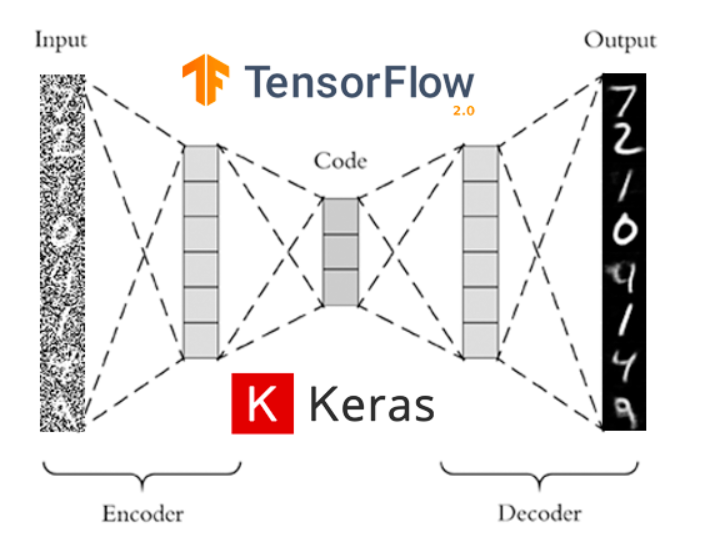

Автоэнкодеры с шумоподавлением - это часть простых автоэнкодеров. Автоэнкодеры шумоподавления изначально не предназначались для автоматического шумоподавления изображений.

Noise canceling autoencoders are part of simple autoencoders. Noise reduction autoencoders were not originally designed for automatic noise reduction of images.



Вместо этого была изобретена процедура шумоподавления автоэнкодера, чтобы:

Instead, an autoencoder squelch procedure was invented to:


* Скрытые слои автоэнкодера обучались с более надежными фильтрами. Hidden autoencoder layers trained with more robust filters
* Уменьшить риск переобучения автокодировщика. Reduce the risk of overtraining the autoencoder
* Запретить автоэнкодеру обучаться с простой функцией идентификации. Prevent autoencoder from learning with simple identification function


### Загрузка файлов
### Download the code zip file

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_37.keras_denoising_autoencoder.zip
!unzip -qq Lesson_37.keras_denoising_autoencoder.zip
%cd /content/Lesson_37.keras_denoising_autoencoder

--2022-02-13 09:10:49--  http://dataudt.ru/datasets/cv/Lesson_37.keras_denoising_autoencoder.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2040358 (1.9M) [application/zip]
Saving to: ‘Lesson_37.keras_denoising_autoencoder.zip’

Lesson_37.keras_den 100%[===================>]   1.95M  2.48MB/s    in 0.8s    

2022-02-13 09:10:50 (2.48 MB/s) - ‘Lesson_37.keras_denoising_autoencoder.zip’ saved [2040358/2040358]

/content/Lesson_37.keras_denoising_autoencoder


### Импорт бибилиотек
### Import Packages

In [2]:
# импортируем необходимые библиотеки
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Функция отображения изображений в Jupyter Notebooks и Google Colab
### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его 
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(10, 10))
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Реализация шумоподавляющего автоэнкодера
### Implementing our denoising autoencoder with Keras and TensorFlow

In [4]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
        # инициализируем вход модели как
		# "последние каналы" и самой размерностью каналов
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

        # определяем вход модели значение для энкодера
		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

        # перебираем все фильтры
		# loop over the number of filters
		for f in filters:
            # применяем свертку => функцию активации RELU => батч-нормализацию
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

        # сгладим сеть, а затем построим наш скрытый вектор
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

        # построим модель энкодера
		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

        # начнем построение модели декодера, которая будет принимать
		# на вход выходные значения энкодера
		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        # снова перебираем все фильтры, но на этот раз в
		# обратном порядке
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
            # применяем свертку => функцию активации RELU => батч-нормализацию
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

        # применяем один слой CONV_TRANSPOSE, используемый для восстановления
		# исходной глубины изображения
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

        # построим модель декодера
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

        # наш автоэнкодер - это энкодер + декодер
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

        # возвращаем кортеж, состоящий из энкодера, декодера и автоэнкодера
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

### Реализация кода шумоподавляющего автоэнкодера
### Implementing the denoising autoencoder training script

In [5]:

# явно укажем аргументы необходимые для работы
# samples - # количество образцов для визуализации при декодировании
# output - путь к выходному файлу визуализации
# plot - путь к файлу выходного графика

# explicitly specify the arguments needed to work
# samples - # number of samples to visualize when decoding
# output - path to output visualization file
# plot - path to output plot file
args = {
	"samples": 8,
	"output": "output.png",
	"plot": "plot.png"
}

In [6]:
# инициализируем количество эпох для обучения и размер батча
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32

# загружаем набор данных MNIST
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# добавляем размерность канала к каждому изображению в наборе данных, затем нормируем
# яркость пикселей в диапазоне [0, 1]
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...
11501568/11490434 [==============================] - 0s 0us/step


In [7]:
# образец шума из случайного нормального распределения с центром 0,5 (поскольку
# наши изображения лежат в диапазоне [0, 1]) и стандартным отклонением 0,5
# sample noise from a random normal distribution centered at 0.5 (since
# our images lie in the range [0, 1]) and a standard deviation of 0.5
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

[INFO] building autoencoder...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
1875/1875 [==============================] - 122s 65ms/step - loss: 0.0274 - val_loss: 0.0194
Epoch 2/25
1875/1875 [==============================] - 121s 65ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 3/25
1875/1875 [==============================] - 122s 65ms/step - loss: 0.0177 - val_loss: 0.0174
Epoch 4/25
1875/1875 [==============================] - 122s 65ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 5/25
1875/1875 [==============================] - 121s 65ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 6/25
1875/1875 [==============================] - 121s 65ms/step - loss: 0.0165 - val_loss: 0.0186
Epoch 7/25
1875/1875 [==============================] - 122s 65ms/step - loss: 0.0162 - val_loss: 0.0166
Epoch 8/25
1875/1875 [==============================] - 122s 65ms/step - loss: 0.0160 - val_loss: 0.0163
Epoch 9/25
1875/1875 [==============================] - 121s 65ms/step - loss: 0.0159 - val_loss: 0.0166
Epoch 10/25
1875/1875 [==============================] 

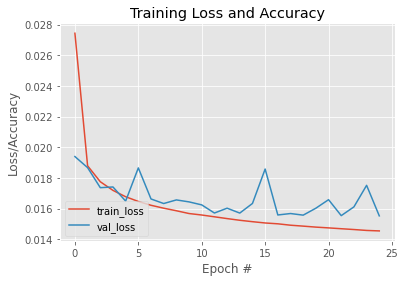

In [8]:
# построим наш сверточный автоэнкодер
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# обучим наш сверточный автоэнкодер
# train the convolutional autoencoder
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=EPOCHS,
	batch_size=BS)

# построим график, который отображает и сохраняет историю обучения
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

Сохраняем модель.

We save the model.

In [9]:
autoencoder.save('model.h5')

При желании можно загрузить уже обученную модель, чтобы не обучать ее повторно.

You can load an already trained model so as not to train it again.

In [10]:
from tensorflow.keras.models import load_model
autoencoder = load_model('model.h5')

[INFO] making predictions...


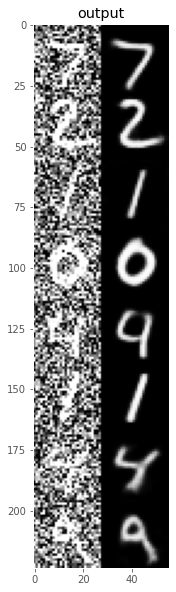

In [11]:
# используем сверточный автоэнкодер, чтобы сделать предсказания на
# тестируемых изображениях, затем инициализируем наш список выходных изображений
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testXNoisy)
outputs = None

# перебираем количество выходных примеров
# loop over our number of output samples
for i in range(0, args["samples"]):
    # возьмем исходное изображение и выходное изображение
	# grab the original image and reconstructed image
	original = (testXNoisy[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
 
    # совмещаем исходное и выходное изображения сторона к стороне
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])
 
    # если выходной массив пуст, инициализируем его как текущее
	# объединенное изображение
	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

    # в противном случае совмещаем выходные изображения вертикально
	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# сохраняем выходное изображение на диск
# save the outputs image to disk and display it
cv2.imwrite(args["output"], outputs)
plt_imshow("output", outputs)